<center><h1><b>Temporal and spatial analysis of earthquakes in Italy in the last century</b></h1></center>

In [1]:
library(ggplot2)
library(maps)
library(dplyr)
library(corrplot)      # to plot nice correlation matrix


Caricamento pacchetto: ‘dplyr’


I seguenti oggetti sono mascherati da ‘package:stats’:

    filter, lag


I seguenti oggetti sono mascherati da ‘package:base’:

    intersect, setdiff, setequal, union


corrplot 0.95 loaded



---

# LOADING DATA
We took the data from https://earthquake.usgs.gov/ in two chunks because there was a limit in the download size. We choose an area a little bigger than Italy, and earthquakes of magnitude of at least 2.5.

In [2]:
df1 = read.table("./data/earthquakes_years_2000_2025.csv", header=TRUE, sep=',')
df2 = read.table("./data/earthquakes_years_1925_2000.csv", header=TRUE, sep=',')
cat("The 1st database has ", nrow(df1), " rows", "\n")
cat("The 2nd database has ", nrow(df2), " rows", "\n")
df_raw = rbind(df1, df2)
cat("The final database has ", nrow(df_raw), " rows", "\n")

The 1st database has  13988  rows 
The 2nd database has  14850  rows 
The final database has  28838  rows 


In [3]:
# Convert the time column to Date format:
df_raw$time <- as.POSIXct(df_raw$time, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")
# let's add the year column:
df_raw$year <- as.integer( format(df_raw$time, "%Y") )
# let's add the month column:
df_raw$month <- as.integer( format(df_raw$time, "%m") )

Let's observe the structure of our data.

In [4]:
summary(df_raw)

      time                            latitude       longitude    
 Min.   :1925-02-07 12:14:58.150   Min.   :35.61   Min.   : 4.66  
 1st Qu.:1990-07-11 12:17:33.473   1st Qu.:39.37   1st Qu.:10.98  
 Median :1999-06-07 03:23:02.495   Median :42.74   Median :15.27  
 Mean   :1997-09-22 00:29:15.603   Mean   :42.17   Mean   :14.92  
 3rd Qu.:2004-10-01 01:05:55.349   3rd Qu.:44.44   3rd Qu.:20.01  
 Max.   :2025-06-24 03:04:54.730   Max.   :47.76   Max.   :20.87  
                                                                  
     depth             mag          magType               nst        
 Min.   : -2.00   Min.   :2.500   Length:28838       Min.   :  0.00  
 1st Qu.:  8.60   1st Qu.:2.700   Class :character   1st Qu.:  7.00  
 Median : 10.00   Median :3.100   Mode  :character   Median : 14.00  
 Mean   : 15.02   Mean   :3.284                      Mean   : 30.35  
 3rd Qu.: 10.00   3rd Qu.:3.600                      3rd Qu.: 35.00  
 Max.   :522.00   Max.   :7.000             

---

# CLEANING

Let's keep only useful columns in the database `df`:

In [5]:
df <- df_raw[, c('time', 'latitude', 'longitude', 'depth', 'mag','place', 'year', 'month') ]
nrow(df)

[1] 28838

In [6]:
# check for NA values in selected columns:
for (col in 1:length(df) ) {
    cat("Number of NA values in column ", col, ": ", sum(is.na( df[1] )), "\n")
}

Number of NA values in column  1 :  0 
Number of NA values in column  2 :  0 
Number of NA values in column  3 :  0 
Number of NA values in column  4 :  0 
Number of NA values in column  5 :  0 
Number of NA values in column  6 :  0 
Number of NA values in column  7 :  0 
Number of NA values in column  8 :  0 


There are no 'Not Available' values.

---

# FILTERS
Let's prepare some useful filters (boolean masks) to apply when needed.

In [26]:
# Filter (boolean mask) to select only earthquakes with magnitude >= 5:
filt_big_magnitude <- (df$mag >=5)

# Filter (boolean mask) to select only those from Italian territory:
filt_italy <- (grepl("Italy", df$place, ignore.case = TRUE ) )

# Filter (boolean mask) to select only those with depth <= threshold:
filt_depth <- (df$depth <=50)

---

# ANALYSIS

#### PLOT OF ALL BIG EARTHQUAKES IN ITALY

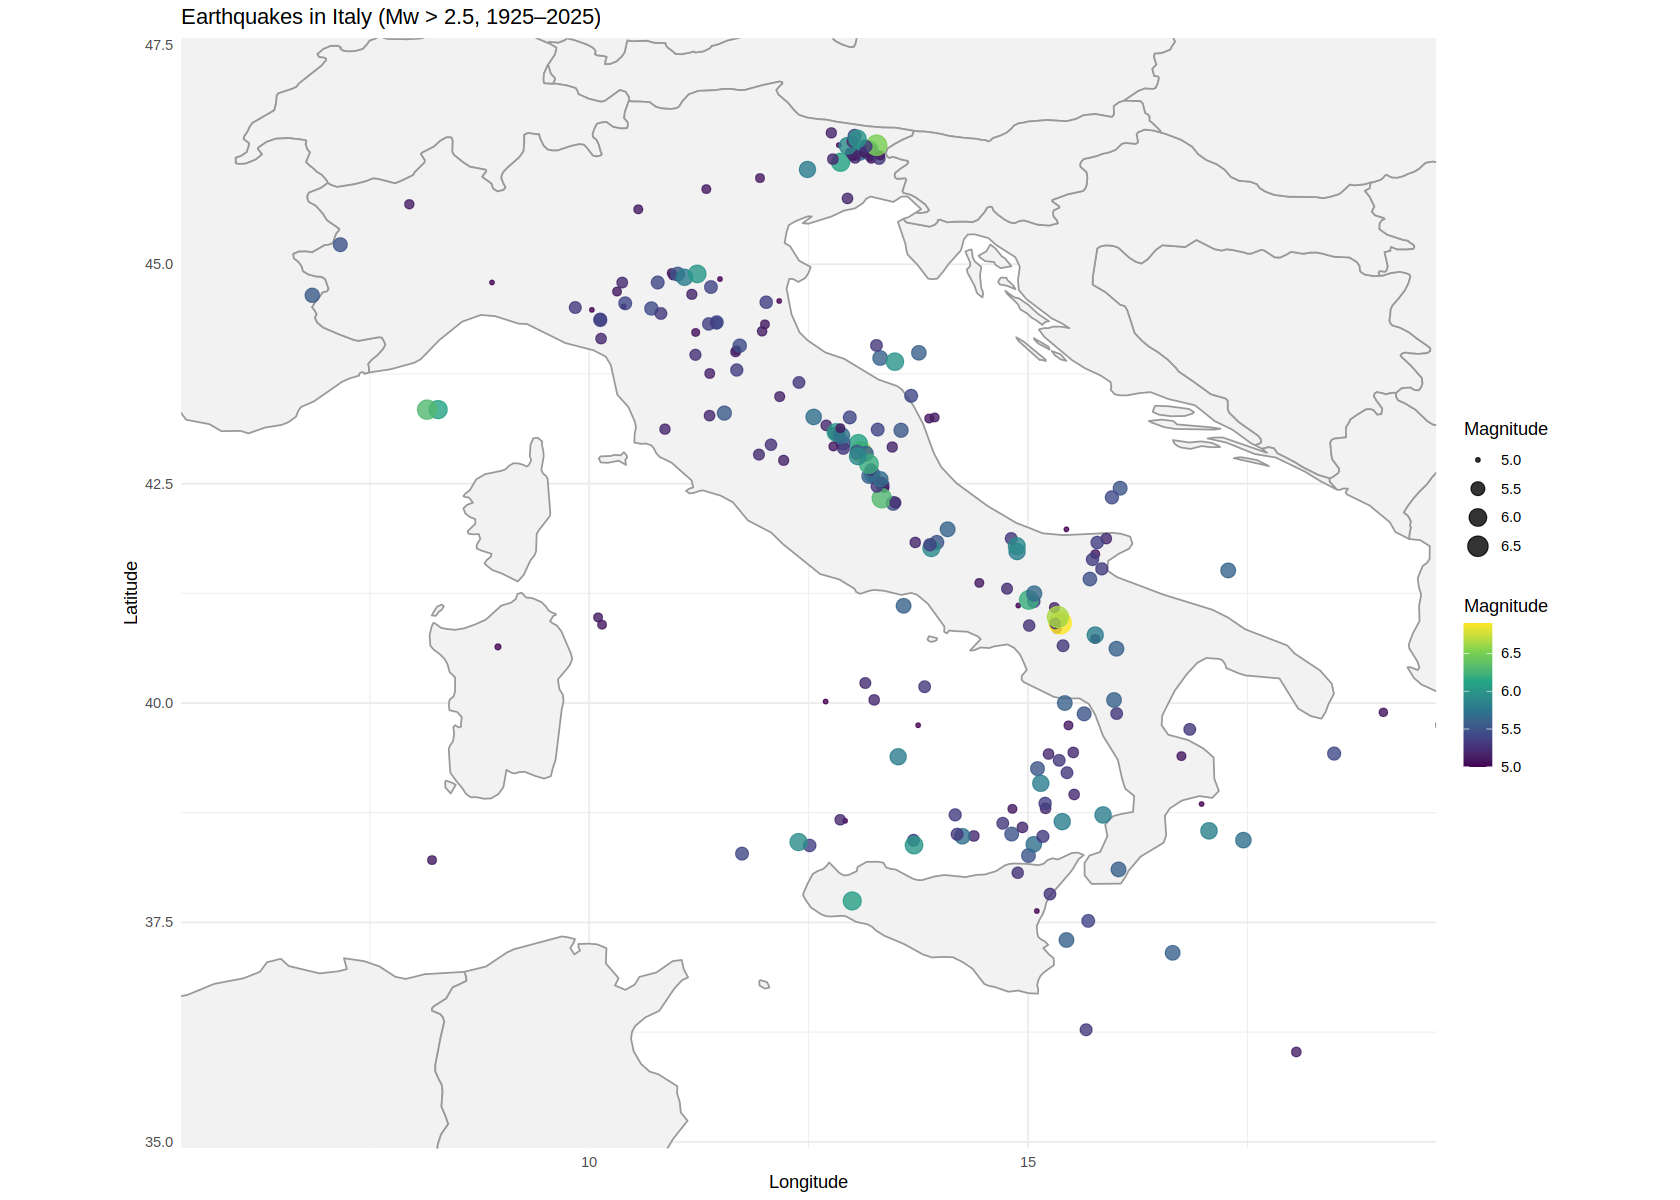

In [8]:
options(repr.plot.width=14, repr.plot.height=10)

ggplot( df[ filt_big_magnitude & filt_italy , ] , aes(x = longitude, y = latitude)) +
  # let's draw the map outline of Italy using the "maps" package
  borders("world", 
          regions = c("Italy", "Germany", "Switzerland", "France", "Austria", "Slovenia", "Croatia", 
                      "Greece", "Albania", 'Bosnia and Herzegovina', 'Hungary', 'Slovakia', 'Liechtenstein', 'Montenegro', 
                      'Serbia', 'Kosovo', 'Romania', 'North Macedonia', 'Tunisia', 'Algeria'), 
          fill = "gray95", colour = "gray60") +
  geom_point(aes(size = mag, color = mag), alpha = 0.8) +
  coord_fixed(xlim = c(6, 19), ylim = c(35.5, 47)) +    #  ensures the aspect ratio is preserved, so the map doesn’t look stretched
  scale_color_viridis_c() +
  labs(title = "Earthquakes in Italy (Mw > 2.5, 1925–2025)",
       x = "Longitude", y = "Latitude", color = "Magnitude", size = "Magnitude") +
  theme_minimal()


#### DENSITY PLOT

Warning message:
“The dot-dot notation (`..level..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(level)` instead.”


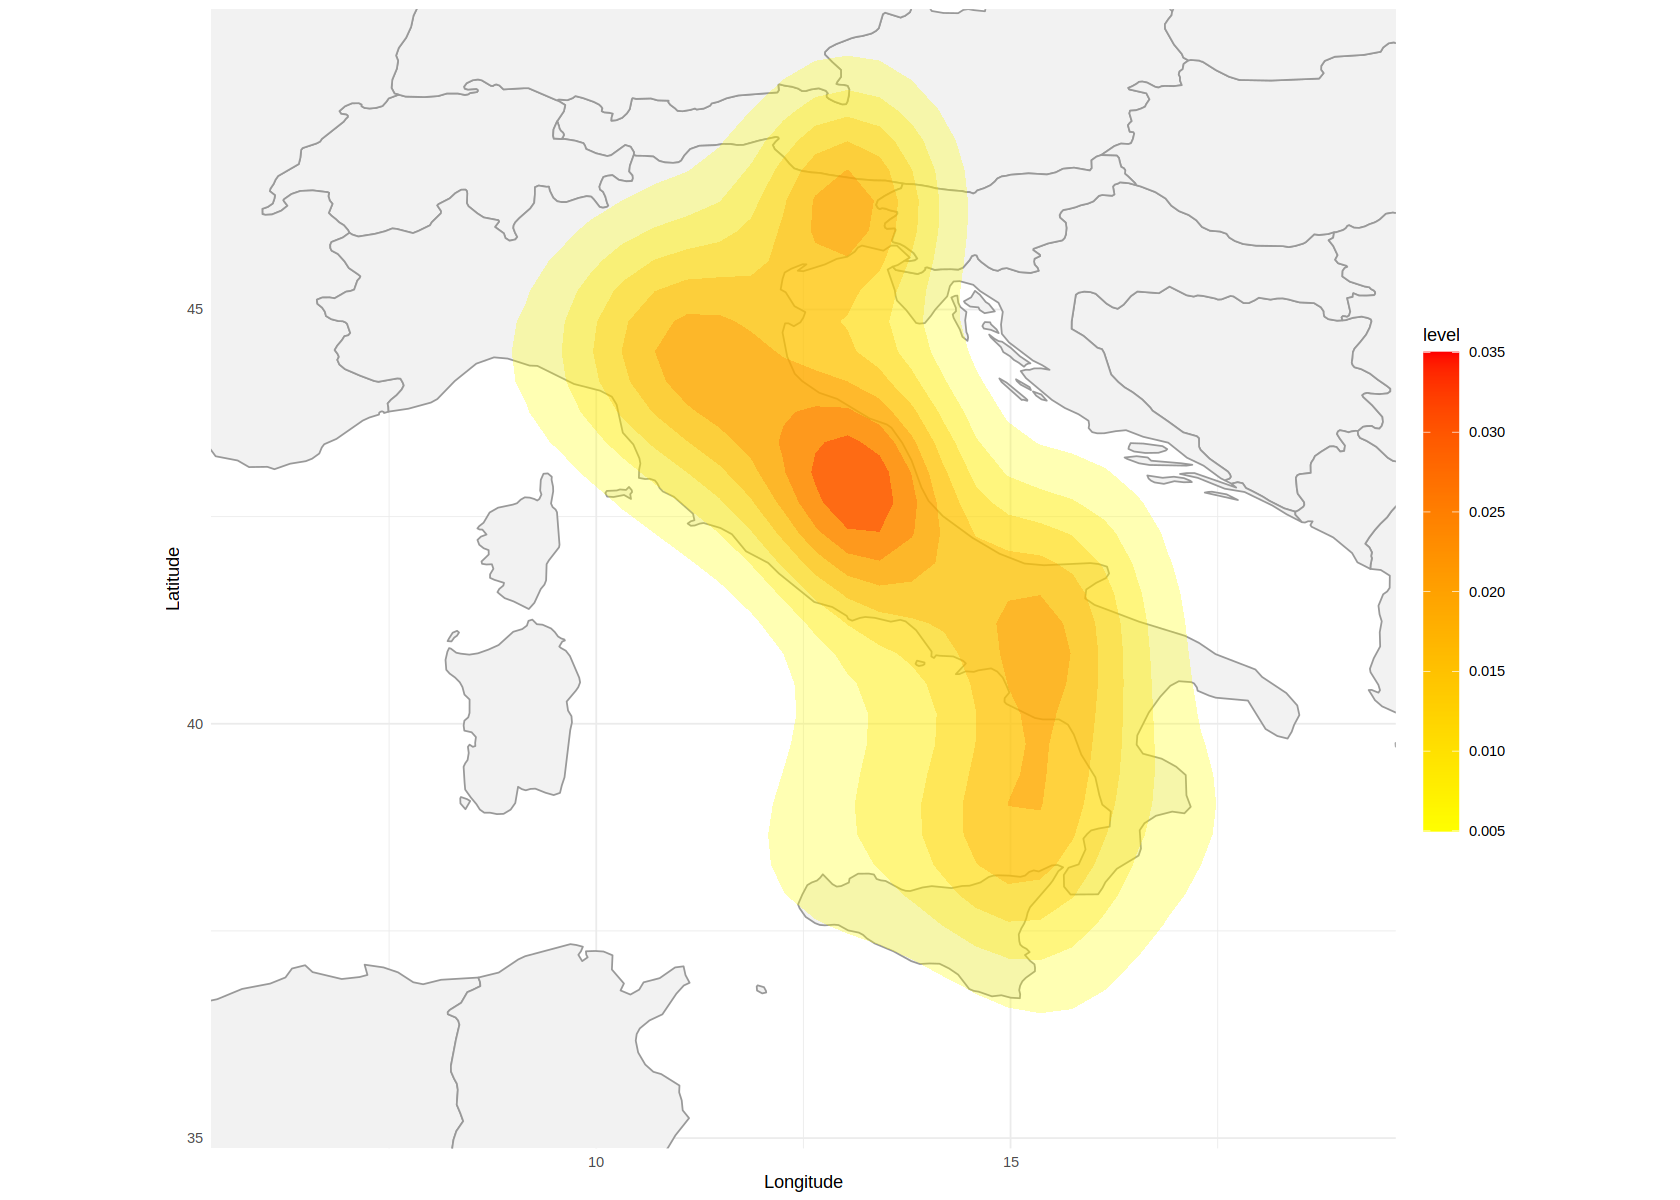

In [9]:
options(repr.plot.width=14, repr.plot.height=10)

ggplot( df[ filt_big_magnitude & filt_italy, ] , aes(x = longitude, y = latitude)) +
  borders("world", 
          regions = c("Italy", "Germany", "Switzerland", "France", "Austria", "Slovenia", "Croatia", 
                      "Greece", "Albania", 'Bosnia and Herzegovina', 'Hungary', 'Slovakia', 'Liechtenstein', 'Montenegro', 
                      'Serbia', 'Kosovo', 'Romania', 'North Macedonia', 'Tunisia', 'Algeria'), 
          , fill = "gray95", colour = "gray60") +
  stat_density_2d(aes(fill = ..level..), geom = "polygon", alpha = 0.3) +
  coord_fixed(xlim = c(6, 19), ylim = c(35.5, 48)) +    #  ensures the aspect ratio is preserved, so the map doesn’t look stretched
  scale_fill_gradient(low = "yellow", high = "red") +
  labs(x = "Longitude", y = "Latitude") +
  theme_minimal() +
  guides(fill = guide_colorbar(barwidth = 1.5, barheight = 20))

### YEAR DISTRIBUTION

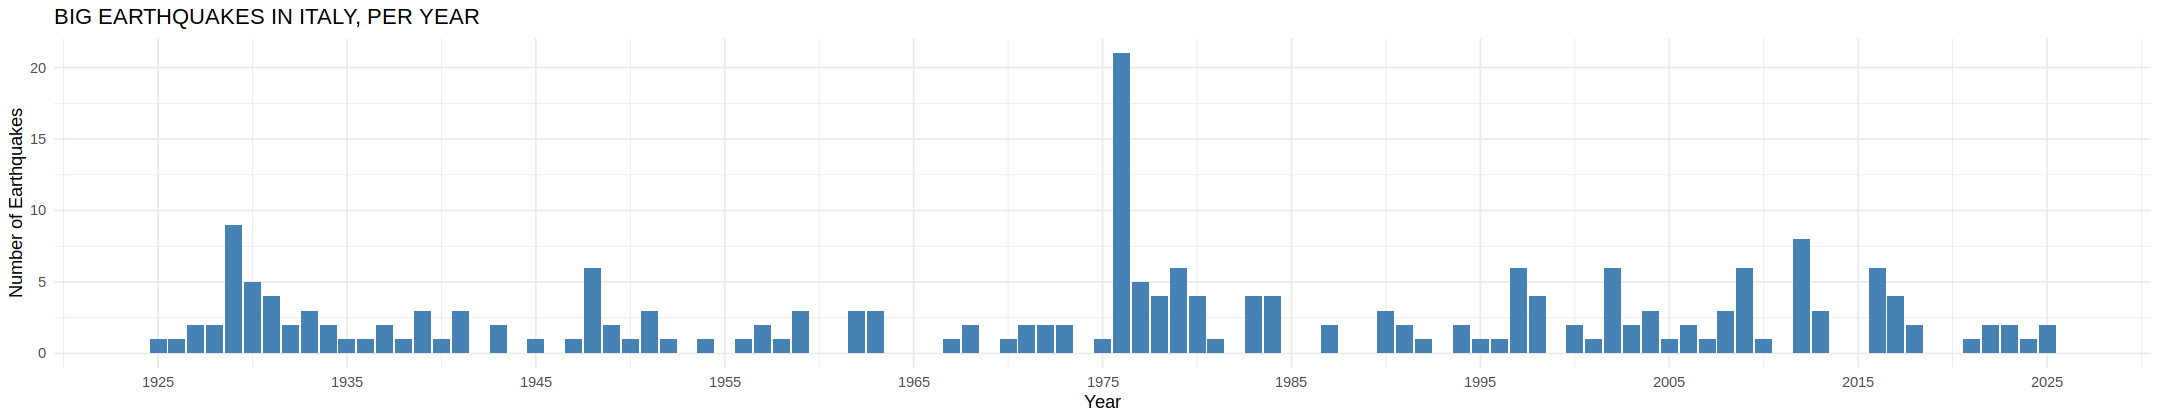

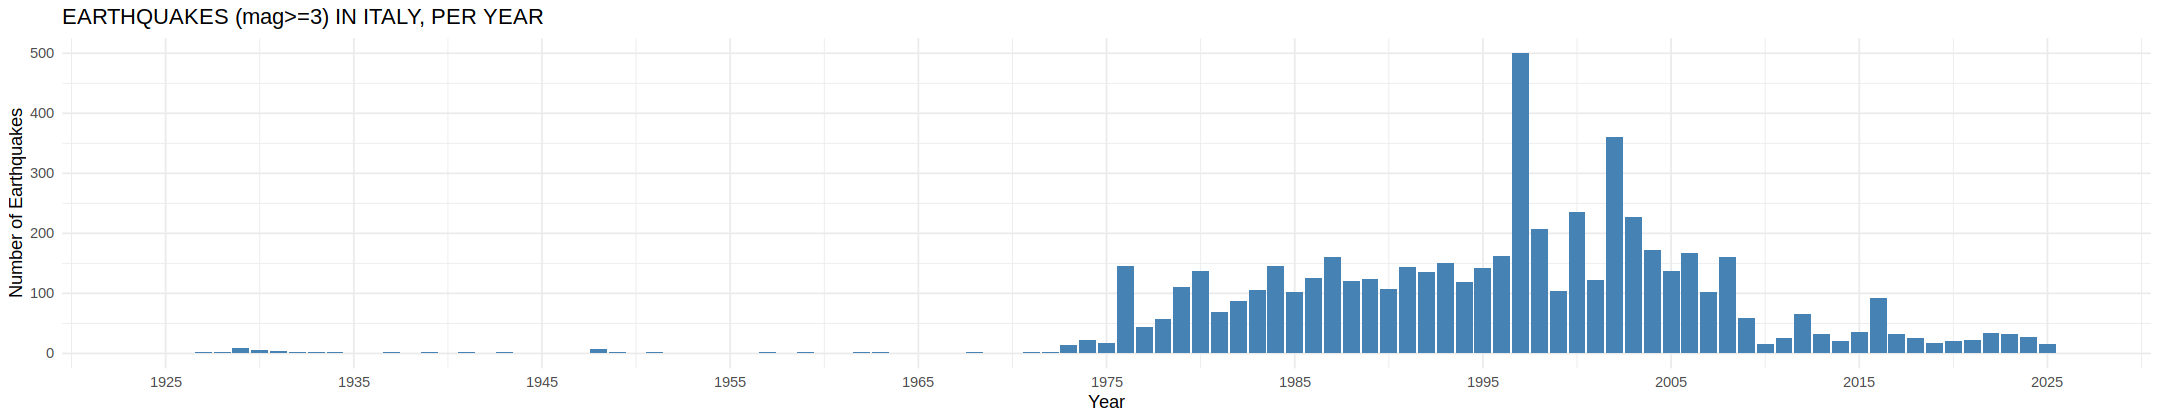

In [10]:
# let's count the number of earthquakes per year:
options(repr.plot.width=18, repr.plot.height=3.5)


# PLOT FOR ITALY AND BIG EARTHQUAKES:
yearly_counts_it <- df[ filt_big_magnitude & filt_italy ,] %>%
  group_by(year) %>%
  summarise( n = n() )

ggplot(yearly_counts_it, aes(x = as.numeric(year), y = n)) +
  geom_col(fill = "steelblue") +
  labs(x = "Year", y = "Number of Earthquakes", title='BIG EARTHQUAKES IN ITALY, PER YEAR') +
  scale_x_continuous(breaks = seq(1925, 2025, by = 10)) +
  theme_minimal()

# PLOT FOR ITALY:
yearly_counts <- df[ (df$mag >=3) & filt_italy ,] %>%
  group_by(year) %>%
  summarise( n = n() )

ggplot(yearly_counts, aes(x = as.numeric(year), y = n)) +
  geom_col(fill = "steelblue") +
  labs(x = "Year", y = "Number of Earthquakes", title='EARTHQUAKES (mag>=3) IN ITALY, PER YEAR') +
  scale_x_continuous(breaks = seq(1925, 2025, by = 10)) +
  theme_minimal()

There are many earthquake registered from 1973 onwards, we can justify it with the better technology.

We can also try to quantify it:
* null hypothesis $H_0$: the number of earthquakes before 1973 is comparable or bigger than later
* alternative hypothesis $H_1$: the number of earthquakes before 1973 is smaller than later

We consider as variable the number of earthquakes in a year, and we assume it follows a Poisson distribution

In general, for $n$ multiple observations $\{y_j\}$, using a Gamma$(\alpha, \lambda)$ prior, we end up with a posterior:
$$
Gamma(\alpha', \lambda')
\quad\quad where \quad\quad
\alpha' = \alpha + \sum y_j, \quad \lambda' = \lambda + n
$$


In [11]:
# Split data by year
df_before_1973 <- yearly_counts %>% filter(year < 1973)
df_after_1973  <- yearly_counts %>% filter(year >= 1973)

# Observed totals and number of years
y_before <- sum(df_before_1973$n)
n_before <- nrow(df_before_1973)
y_after <- sum(df_after_1973$n)
n_after <- nrow(df_after_1973)
mean_before <- y_before/n_before

# Hyperparameters of Gamma(alpha, beta)
alpha_pr <- y_before
beta_pr <- n_before
alpha_post <- alpha_pr + y_after
beta_post <- beta_pr + n_after

# Distributions. Rememeber that: Gamma(alpha + total counts, beta + number of years)
prior <- rgamma(10000, alpha_pr, beta_pr)
posterior  <- rgamma(10000, alpha_post, beta_post)

# p-value:
pvalue <- pgamma(mean_before, alpha_post, beta_post)

# Display Bayesian result
cat("Bayesian P(lambda after 1973 <= lambda before 1973):", pvalue, "\n")
if (pvalue < 0.05) {
  cat("Reject H0 at alpha =", 0.05, " (Bayesian)\n")
} else {
  cat("Do not reject H0 at alpha =", 0.05, "\n")
}


Bayesian P(lambda after 1973 <= lambda before 1973): 0 
Reject H0 at alpha = 0.05  (Bayesian)


There is pretty strong evidence that the rate of earthquakes after 1973 is higher than it was before 1973. Our guess is the improvement i technology.

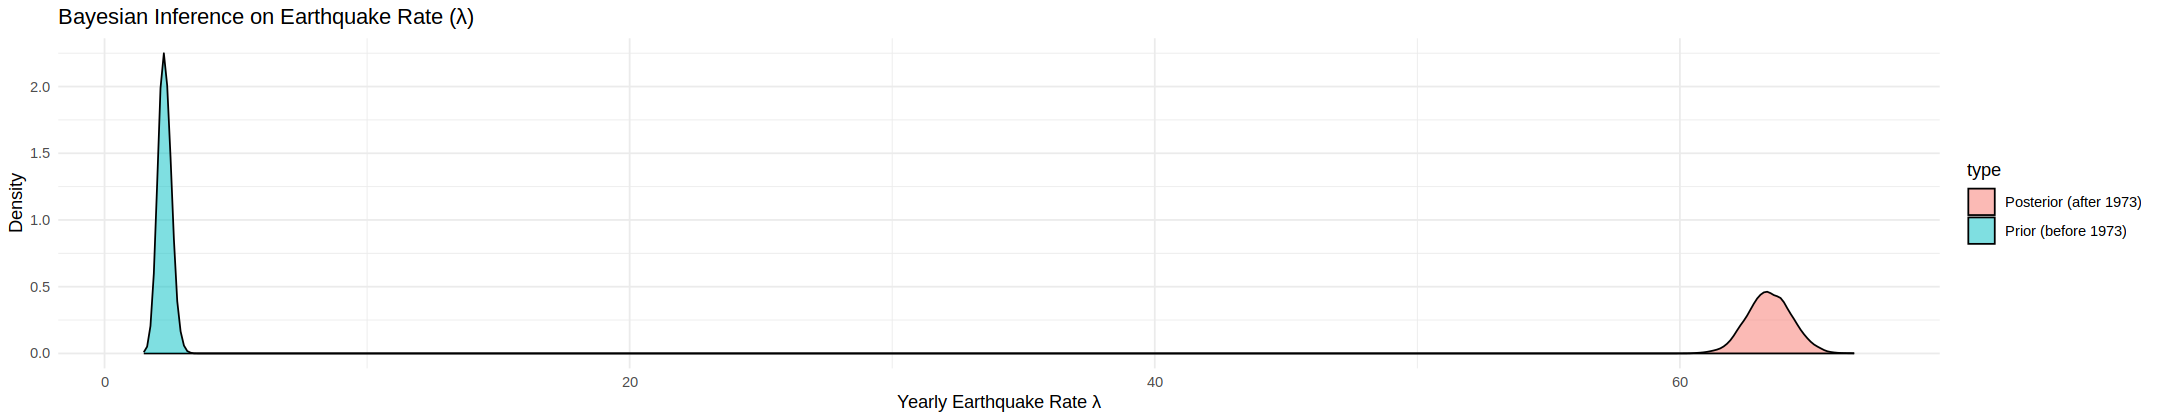

In [12]:
df_plot <- data.frame(
  lambda = c(prior, posterior),
  type = rep(c("Prior (before 1973)", "Posterior (after 1973)"), each = 10000)
)

ggplot(df_plot, aes(x = lambda, fill = type)) +
  geom_density(alpha = 0.5) +
  labs(title = "Bayesian Inference on Earthquake Rate (λ)",
       x = "Yearly Earthquake Rate λ", y = "Density") +
  theme_minimal()


### MONTH DISTRIBUTION

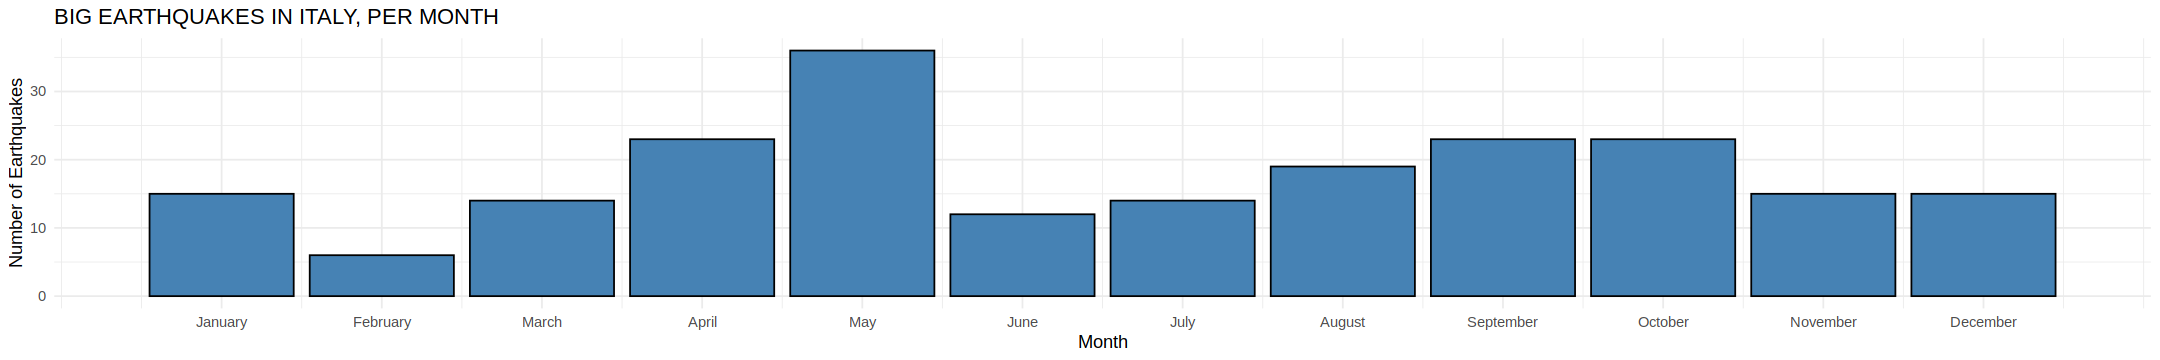

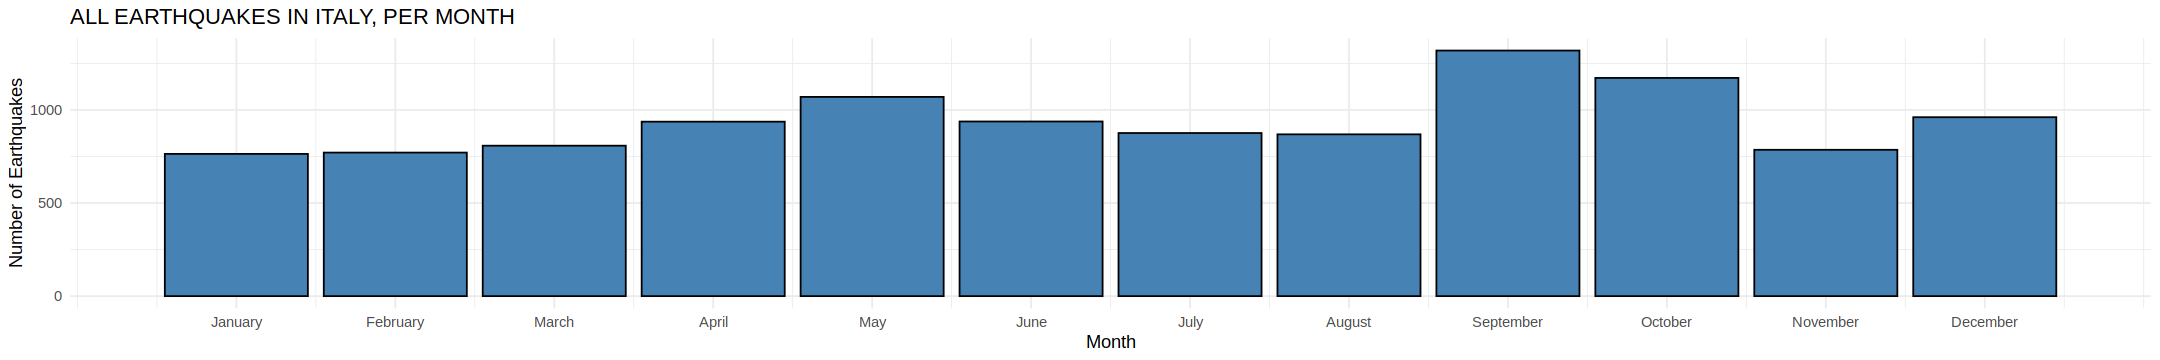

In [13]:
# let's count the number of earthquakes per year:
options(repr.plot.width=18, repr.plot.height=3)
months <- c("January", "February", "March", "April", "May", "June", 
            "July", "August", "September", "October", "November", "December")


# PLOT FOR ITALY AND BIG EARTHQUAKES:
monthly_counts_it <- df[ filt_big_magnitude & filt_italy ,] %>%
  group_by(month) %>%
  summarise( n = n() )

ggplot(monthly_counts_it, aes(x = as.numeric(month), y = n)) +
  geom_col(fill = "steelblue", color = "black") +
  labs(x = "Month", y = "Number of Earthquakes", title='BIG EARTHQUAKES IN ITALY, PER MONTH') +
  scale_x_continuous( breaks = 1:12, labels = months ) +
  theme_minimal()

# PLOT FOR ITALY:
monthly_counts <- df[ filt_italy ,] %>%
  group_by(month) %>%
  summarise( n = n() )

ggplot(monthly_counts, aes(x = as.numeric(month), y = n)) +
  geom_col(fill = "steelblue", color = "black") +
  labs(x = "Month", y = "Number of Earthquakes", title='ALL EARTHQUAKES IN ITALY, PER MONTH') +
  scale_x_continuous( breaks = 1:12, labels = months ) +
  theme_minimal()

There is no evident seasonal ditribution.

In [14]:
# debug:
test <- data.frame( yearly_counts_it )
test$year <- as.integer( test$year)
missing <- setdiff(seq(min(test$year), max(test$year)), test$year)
print(missing)

 [1] 1942 1944 1946 1953 1955 1960 1961 1964 1965 1966 1969 1974 1982 1985 1986
[16] 1988 1989 1993 1999 2011 2014 2015 2019 2020


In [15]:
# debug: how many earthquakes in each year
table(df[ filt_italy , "year"])


1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 
   1    1    2    2    9    5    4    2    3    3    1    1    2    1    3    1 
1941 1943 1945 1947 1948 1949 1950 1951 1952 1954 1956 1957 1958 1959 1962 1963 
   3    2    1    1    8    2    1    3    1    1    1    2    1    3    3    3 
1967 1968 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 
   1    2    1    2    2   14   22   18  150   47   59  113  143   79  103  144 
1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 
 167  147  195  242  274  305  222  282  245  332  272  257  270  679  341  221 
2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 
 447  295 1253  923  688  467  455  309  411   59   15   26   66   33   21   35 
2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 
  93   34   29   21   22   24   35   33   29   20 

---

## CORRELATION BETWEEN VARIABLES
Memo: the corr function search only for **linear** correlation.

In [16]:
# Select relevant numeric columns:
df_cor <- df[ , c("time", "depth", "longitude", "latitude", "mag")]
df_cor$time <- as.numeric(df_cor$time)  # change time to numeric value (seconds since 1970-01-01)

# Compute correlation matrix
cor_matrix <- cor( df_cor, use = "complete.obs", method = "pearson")

# Print matrix
print(cor_matrix)

                  time        depth   longitude   latitude        mag
time       1.000000000  0.007388902  0.05066284 -0.1590994 -0.1212677
depth      0.007388902  1.000000000  0.04583839 -0.1539860  0.1723716
longitude  0.050662845  0.045838388  1.00000000 -0.6282525  0.3208202
latitude  -0.159099432 -0.153985984 -0.62825252  1.0000000 -0.3278904
mag       -0.121267665  0.172371571  0.32082016 -0.3278904  1.0000000


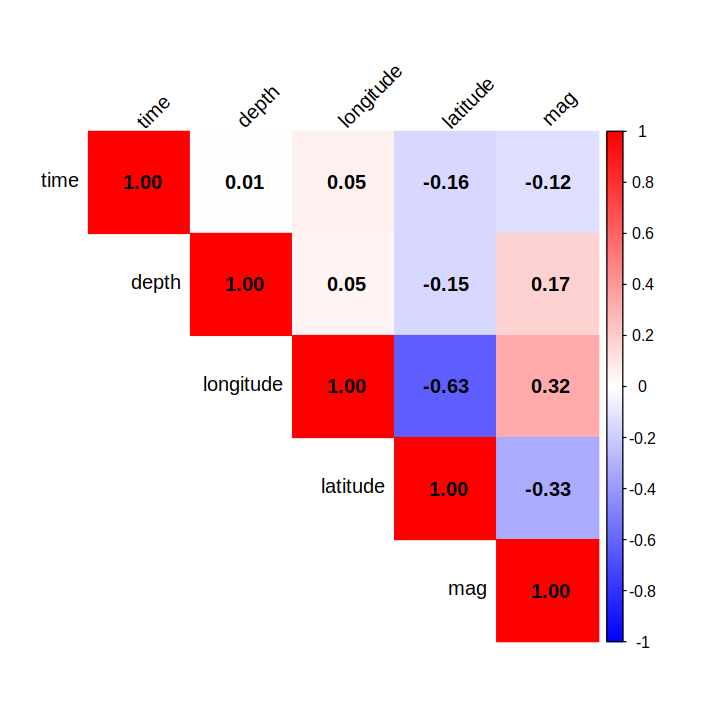

In [17]:
# PLOT HEATMAP:
options(repr.plot.width=6, repr.plot.height=6)

# Plot the correlation matrix
corrplot(cor_matrix,
         method = "color",
         type = "upper",              # shows only the upper triangle of the matrix
         addCoef.col = "black",       # adds the actual correlation coefficient values on top of each square, in black
         tl.col = "black",            # label color
         tl.srt = 45,                 # label rotation (45 degrees)
         col = colorRampPalette(c("blue", "white", "red"))(200)
)

The strongest correlation is observed between latitude and longitude, likely reflecting the geographical alignment of the Apennine mountain range, which follows a tectonic plate boundary.

`geom_smooth()` using formula = 'y ~ x'


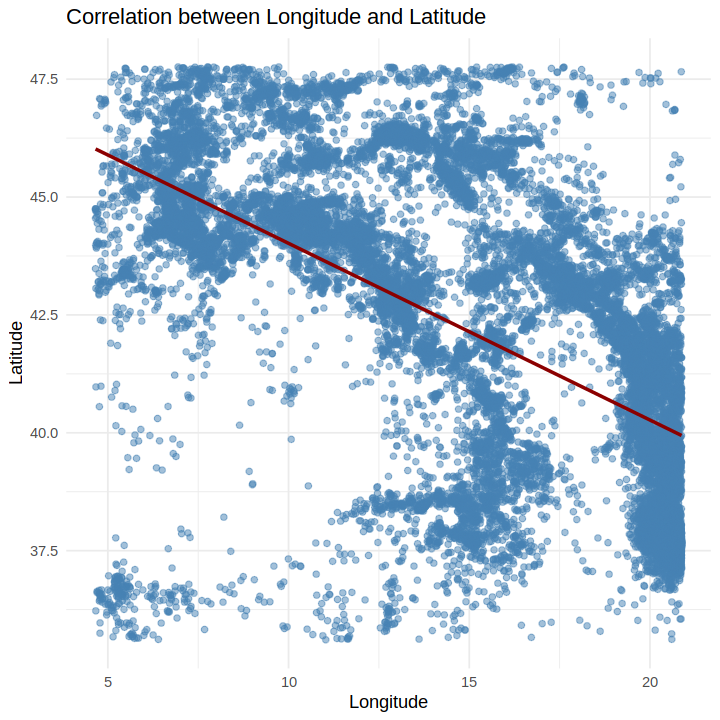

In [18]:
# PLOT:
options(repr.plot.width=6, repr.plot.height=6)
ggplot( df_cor, aes(x = longitude, y = latitude)) +
  geom_point(alpha = 0.5, color = "steelblue") +
  geom_smooth(method = "lm", se = FALSE, color = "darkred") +
  labs(title = "Correlation between Longitude and Latitude",
       x = "Longitude", y = "Latitude") +
  theme_minimal()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


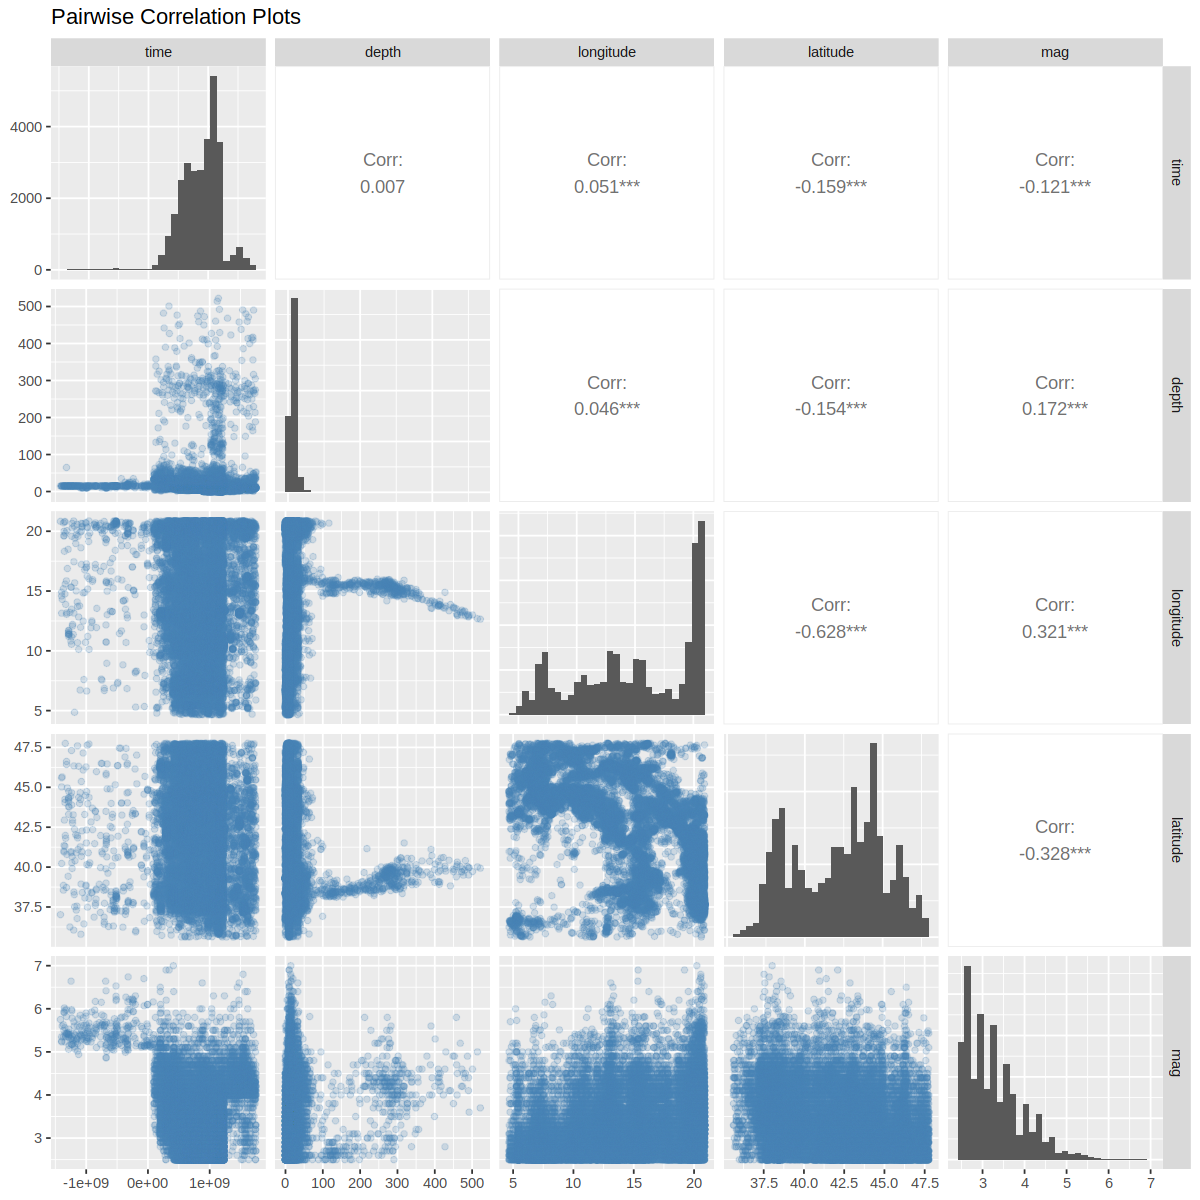

In [19]:
library(GGally)

# Create the scatterplot matrix
options(repr.plot.width=10, repr.plot.height=10)
ggpairs(df_cor,
        title = "Pairwise Correlation Plots",
        lower = list(continuous = wrap("points", alpha = 0.2, color = "steelblue")), 
        diag = list(continuous = "barDiag"),
        upper = list(continuous = "cor"))

---

## STUDY GUTENBERG-RICHTER LAW
1) Compute the Gutenberg-Richter relationship: For each magnitude threshold M, count how many earthquakes have magnitude ≥ M. Plot log10(N) versus M.
2) Estimate the parameters a and b: Fit a linear regression: log10(N) = a + b * M (Note: the slope will be negative) Use lm() in R.
3) Interpret the b value: It tells you the relative proportion of small vs large earthquakes. b ≈ 1 is typical; lower b means relatively more large quakes.

MEMO: 
$$ log_{10} ⁡ N = a − b \cdot M $$


### EXPLANATION
In seismology, the Gutenberg–Richter law (GR law) expresses the relationship between the magnitude and total number of earthquakes in any given region and time period of at least that magnitude, and is given by:
$$ log_{10} ⁡ N = a − b \cdot M $$

where $N$ is the number of events having a magnitude ≥ $M$, $a$ and $b$ are constants. The values of $a$ and $b$ may vary significantly from region to region or over time.   

#### PARAMETER $b$
The parameter $b$ is commonly close to 1.0 in seismically active regions. This means that for a given frequency of magnitude 4.0 or larger events there will be 10 times as many magnitude 3.0 or larger quakes and 100 times as many magnitude 2.0 or larger quakes. There is some variation of b-values in the approximate range of 0.5 to 2 depending on the source environment of the region. A notable example of this is during earthquake swarms when b can become as high as 2.5, thus indicating a very high proportion of small earthquakes to large ones.  Alternatively, a b-value significantly different from 1.0 may suggest a problem with the data set; e.g. it is incomplete or contains errors in calculating magnitude. 

#### PARAMETER $a$
The a-value represents the total seismicity rate of the region. This is more easily seen when the GR law is expressed in terms of the total number of events: 
$$ N = N_{TOT} \cdot 10^{-bM} $$ 
with $N_{TOT} = 10^{a}$ the total number of events. Since $10^{a}$ is the total number of events, $10^{-bM}$ must be the probability of those events. 


In [20]:
mag_values <- seq(5,7,0.1)  # groups of magnitudes (one every 0.1)
y_counts <- c()             # empty for now. It will count how many earthquakes there are in each group of magnitude

for (i_mag in mag_values) {
    count <- df[ filt_big_magnitude & filt_italy ,] %>%
        filter( mag >= i_mag )%>%
        summarize( count= n() ) %>%
        pull(count)  # extract the number instead of returning a dataframe
    y_counts <- append(y_counts, count)
    }
y_counts

[1] 215 198 154 123  85  71  54  40  32  24  16  11   8   6   4   4   3   1   1
[20]   1   0

`geom_smooth()` using formula = 'y ~ x'


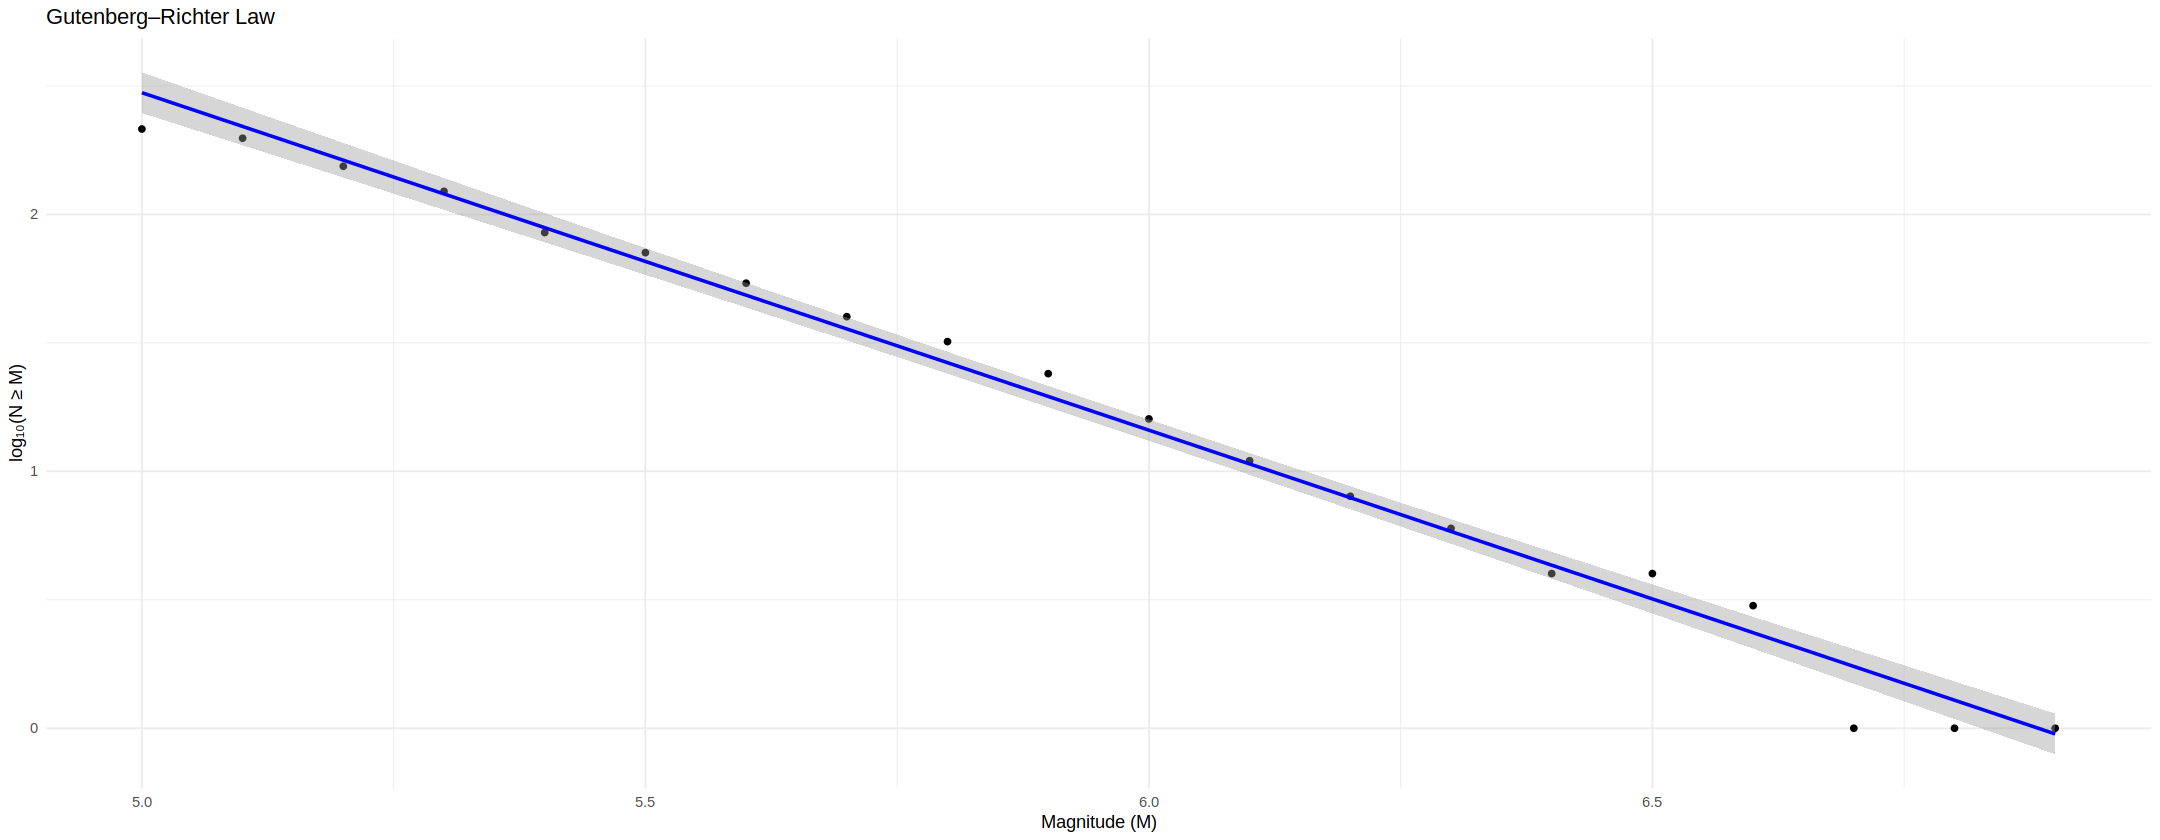

In [21]:
# let's create a dataframe with results for the PLOT
gut_rich <- data.frame(
    mag_lim = mag_values,
    y_counts = y_counts
)

# let's create a filter to exclude the case of log10(0):
gut_rich_clean <- gut_rich[ gut_rich$y_counts > 0, ]

options(repr.plot.width=18, repr.plot.height=7)
ggplot(gut_rich_clean, aes(x = mag_lim, y = log10(y_counts))) +
  geom_point() +
  geom_smooth(method = "lm", color = "blue") +
  labs(title = "Gutenberg–Richter Law",
       x = "Magnitude (M)",
       y = "log₁₀(N ≥ M)") +
  theme_minimal()

In [22]:
model <- lm(log10(y_counts) ~ mag_lim, data = gut_rich_clean)

coeffs <- coef(model)
ci <- confint(model)
a <- coeffs[1]        # intercept
b <- -coeffs[2]       # negative slope, because of how it is defined (see law definition)

cat("Estimated a:", a, "\n")
cat("95% CI for a (intercept):", ci[1,1], "to", ci[1,2], "\n\n")
cat("Estimated b:", b, "\n")
cat("95% CI for b (slope):", -ci[2,2], "to", -ci[2,1], "\n")  # remember to flip the sign

Estimated a: 9.042364 
95% CI for a (intercept): 8.616194 to 9.468533 

Estimated b: 1.313716 
95% CI for b (slope): 1.242425 to 1.385007 


Maybe do it also with also including small earthquakes and confront.

---

## DEPTH DISTRIBUTION
Let's study the depth distribution of the earthquakes.

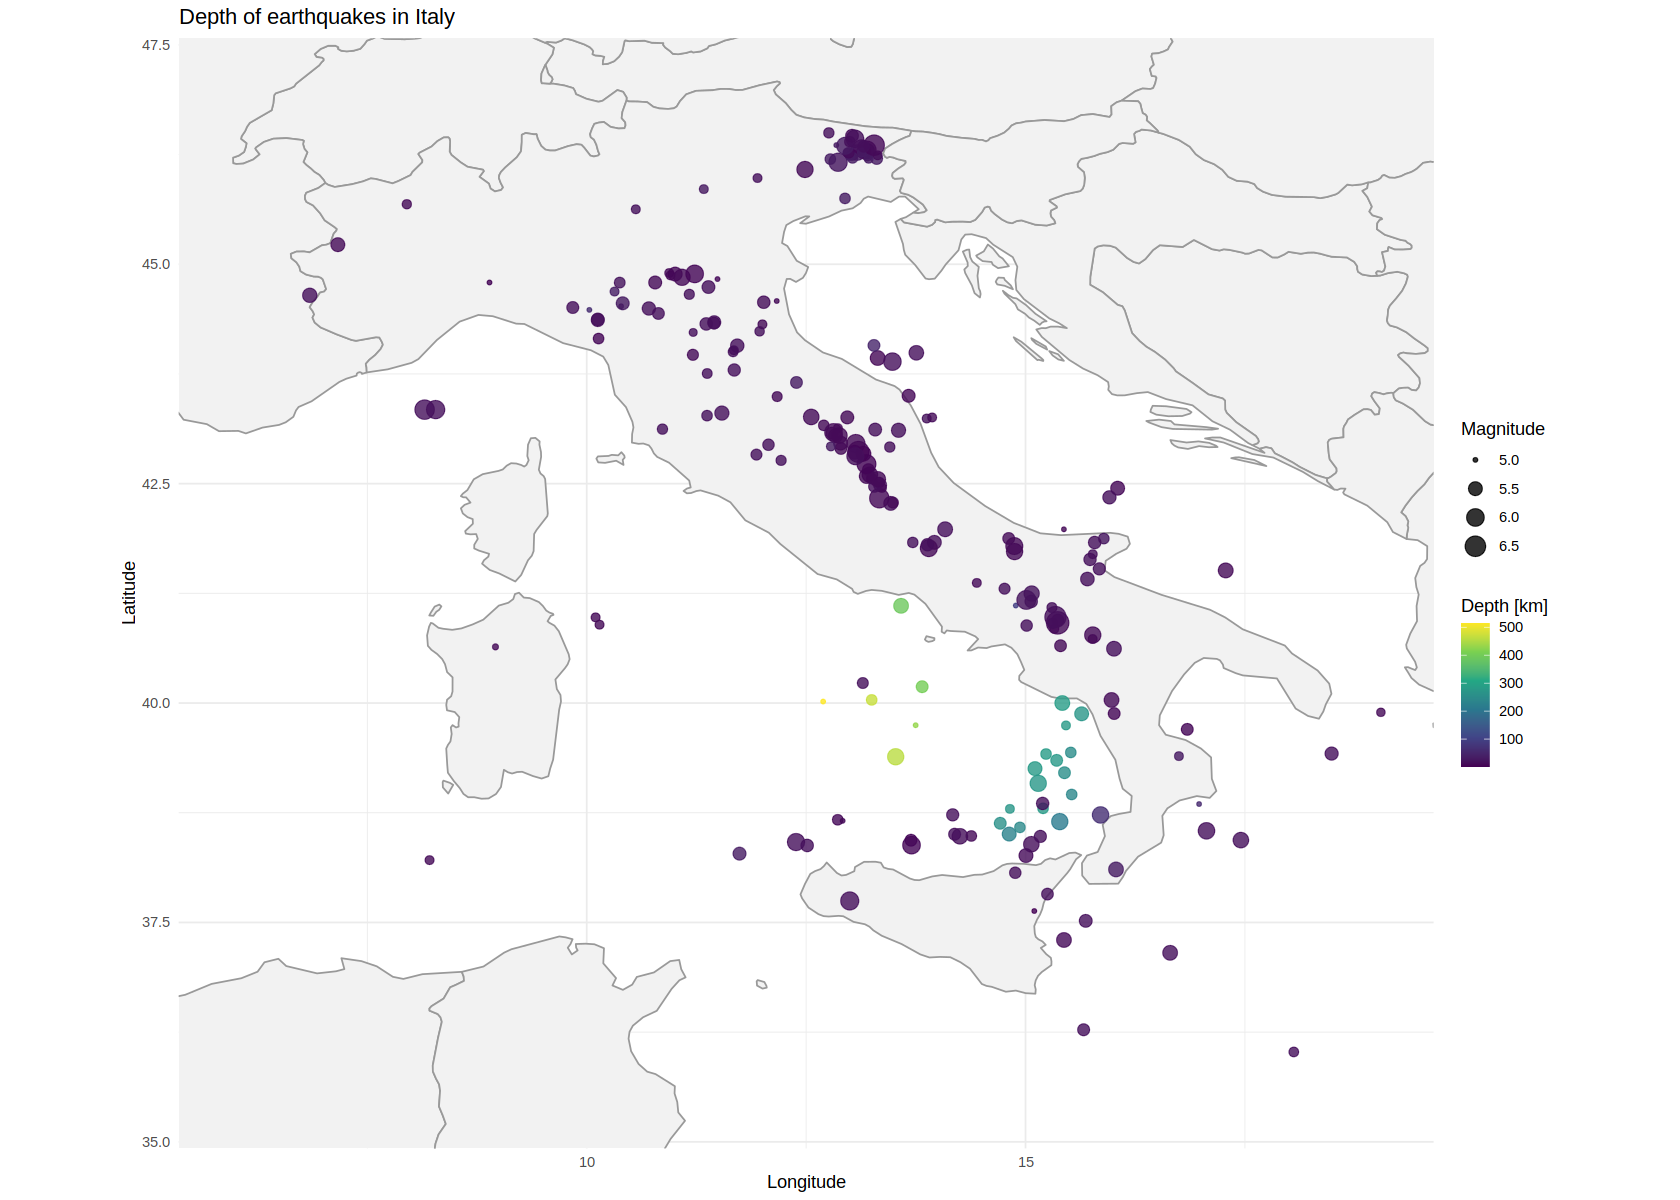

In [23]:
options(repr.plot.width=14, repr.plot.height=10)

ggplot( df[ filt_big_magnitude & filt_italy , ] , aes(x = longitude, y = latitude)) +
  # let's draw the map outline of Italy using the "maps" package
  borders("world", 
          regions = c("Italy", "Germany", "Switzerland", "France", "Austria", "Slovenia", "Croatia", 
                      "Greece", "Albania", 'Bosnia and Herzegovina', 'Hungary', 'Slovakia', 'Liechtenstein', 'Montenegro', 
                      'Serbia', 'Kosovo', 'Romania', 'North Macedonia', 'Tunisia', 'Algeria'), 
          fill = "gray95", colour = "gray60") +
  geom_point(aes(size = mag, color = depth), alpha = 0.8) +
  coord_fixed(xlim = c(6, 19), ylim = c(35.5, 47)) +    #  ensures the aspect ratio is preserved, so the map doesn’t look stretched
  scale_color_viridis_c() +
  labs(title = "Depth of earthquakes in Italy",
       x = "Longitude", y = "Latitude", color = "Depth [km]", size = "Magnitude") +
  theme_minimal()


It's clear the presence of a deep seismic active zone between Sicilia and Calabria regions. Let's study better the depth distribution:

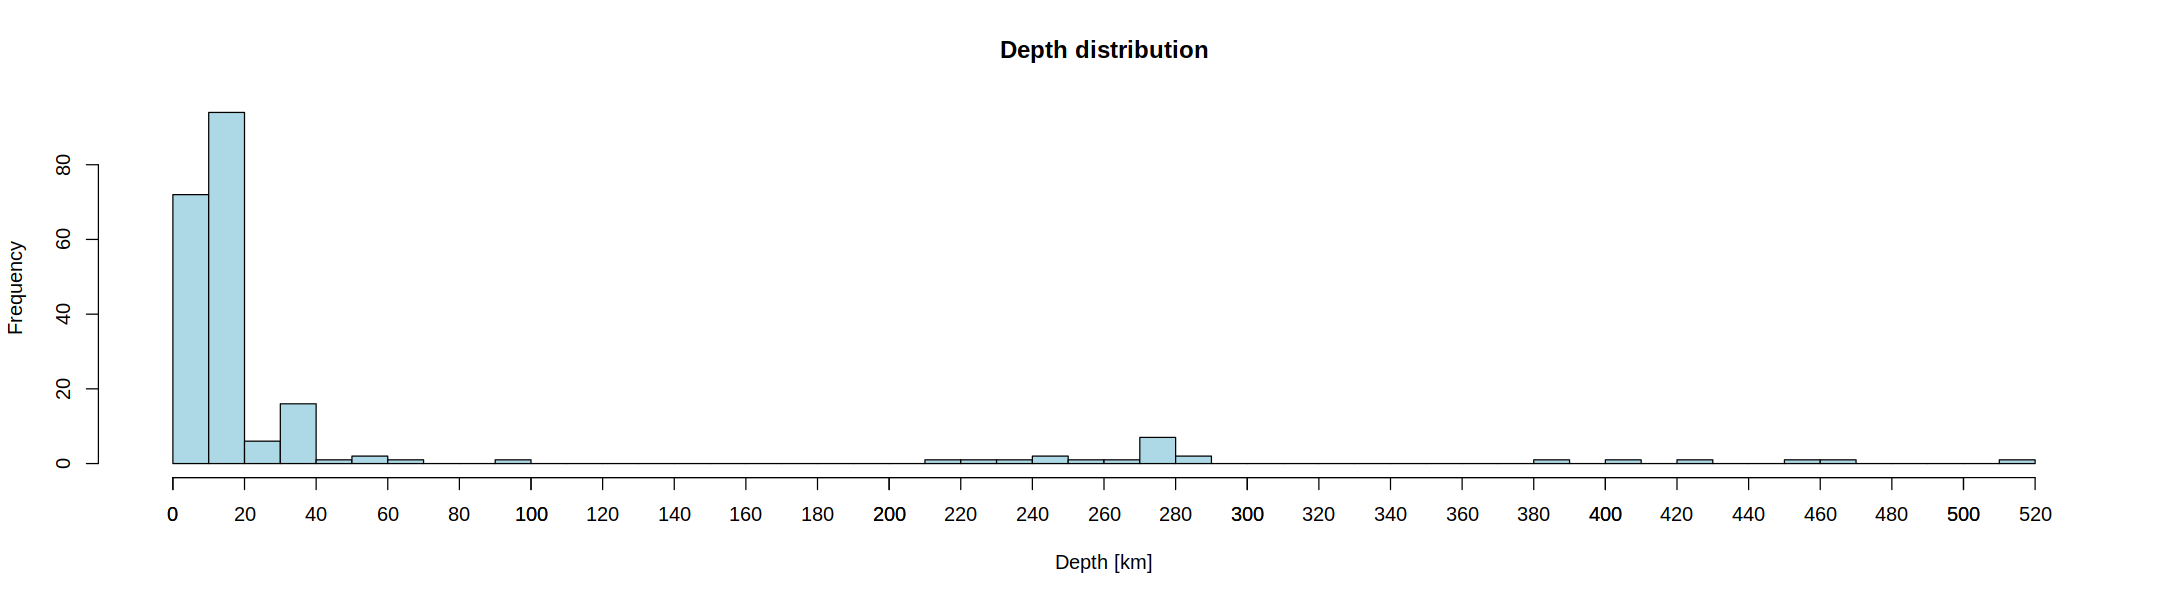

In [24]:
options(repr.plot.width=18, repr.plot.height=5)

hist( df[ filt_big_magnitude & filt_italy , ]$depth, breaks=50,
    main="Depth distribution", xlab='Depth [km]', col='lightblue')
axis(side = 1, at = seq(0, 520, by = 20))



We can identify three main depth zones:
* 0-100 km, with a peak at low depth
* 200-300 km
* 380-520 km

The last two zones coincide exactly with the high depth zone seen in the map.

The deep earthquakes we see in the sea northwest of Sicily and west of Calabria are almost certainly due to the subduction of the Ionian plate beneath the Calabrian arc. This area is one of Europe’s most active deep seismic zones, and its depth pattern strongly supports the presence of a steeply dipping, active subduction zone. This conncets with notorious volanos in the zone (Vesuvio, Etna, Stromboli, Vulcano...).

ADD MAP WITH TECTONIC PLATES.

### YEARLY DISTRIBTUION OF DEPTH

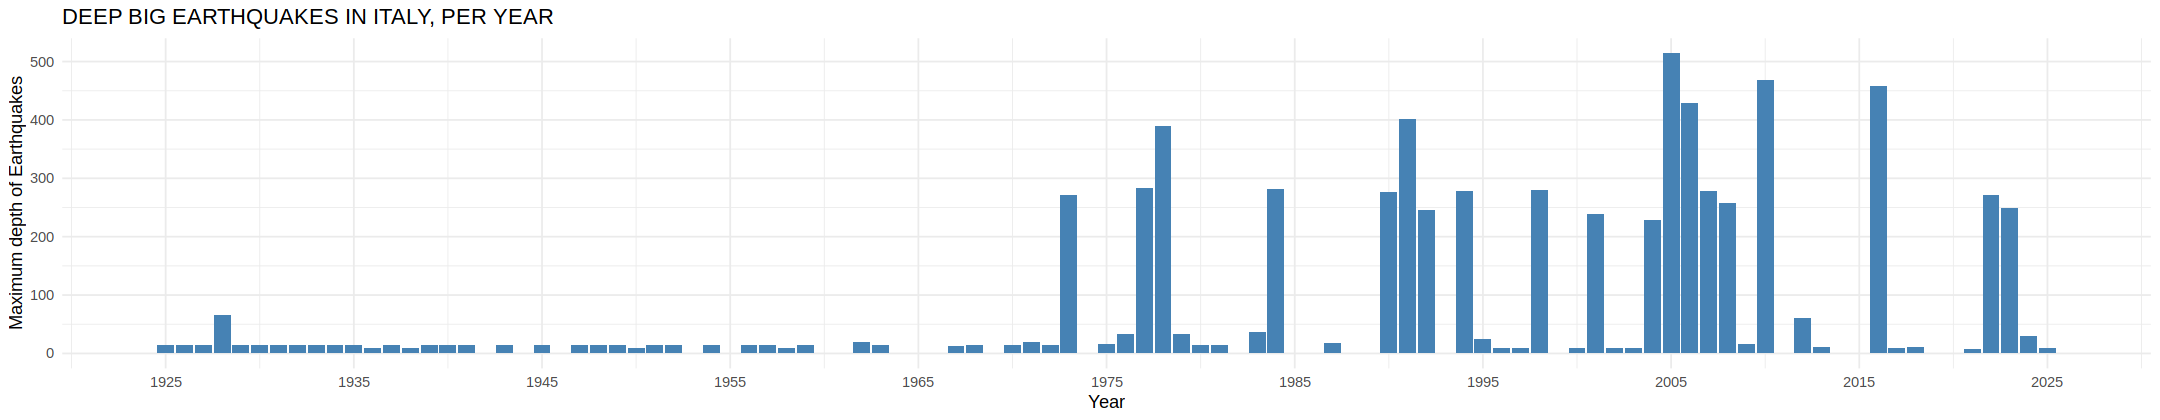

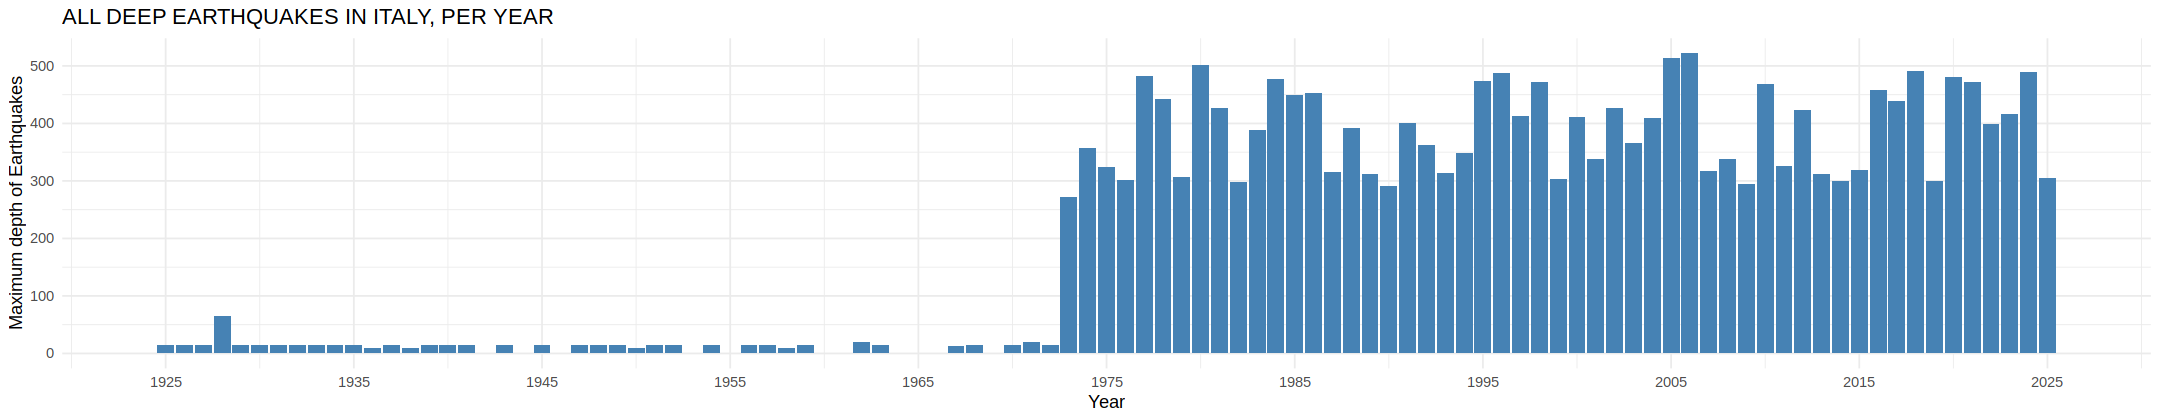

In [25]:
# let's count the number of earthquakes per year:
options(repr.plot.width=18, repr.plot.height=3.5)


# PLOT FOR ITALY AND BIG EARTHQUAKES:
depth_yearly_it <- df[ filt_big_magnitude & filt_italy ,] %>%
  group_by(year) %>%
  summarise( max = max(depth) )

ggplot(depth_yearly_it, aes(x = as.numeric(year), y = max)) +
  geom_col(fill = "steelblue") +
  labs(x = "Year", y = "Maximum depth of Earthquakes", title='DEEP BIG EARTHQUAKES IN ITALY, PER YEAR') +
  scale_x_continuous(breaks = seq(1925, 2025, by = 10)) +
  theme_minimal()

# PLOT FOR ITALY:
depth_yearly <- df[ filt_italy ,] %>%
  group_by(year) %>%
  summarise( max = max(depth) )

ggplot(depth_yearly, aes(x = as.numeric(year), y = max)) +
  geom_col(fill = "steelblue") +
  labs(x = "Year", y = "Maximum depth of Earthquakes", title='ALL DEEP EARTHQUAKES IN ITALY, PER YEAR') +
  scale_x_continuous(breaks = seq(1925, 2025, by = 10)) +
  theme_minimal()

Deep earthquakes in Italy are only recorded from 1975 onward, likely reflecting improved seismic monitoring. Further analysis would be needed to determine whether this reflects a true onset of activity or increased detection capability. 


#### OTHER MODELS
The basic model is the Gutenberg Richter
(GR) model that states the frequency’s logarithm is linearly
dependent on the magnitude. However, Dargahi-Noubary
(1986) and Kagan (1993) suggest that more suitable sta-
tistical models should be used instead of the GR model for
the distribution with high magnitudes. Petersen et al. (2007)
proposed a time-independent model showing that the prob-
ability of earthquake occurrence follows the Poisson dis-
tribution. Considering the time of earthquakes, stochastic
processes, especially Poisson processes, have also been used
to predict the number of earthquakes. However, the Poisson
model cannot be sufficient since it has an exponential recur-
rence time distribution and a constant hazard function. This
assumes that the probability of observing an earthquake at
any given time is independent of both elapsed time since
the last earthquake and its severity. This assumption leads
only to time-independent seismic hazard estimates. Besides,
earthquakes are clustered in time and space and their distri-
bution is over-dispersed compared to the Poisson law. [5]

In recent times, taking into account the seasonality and
trends of earthquakes, the prediction of the size or mag-
nitude has been performed in a few studies by time series
models such as Auto-Regressive Integrated Moving Aver-
age (ARIMA) and generalized autoregressive conditional
heteroskedasticity (GARCH).

a NEW BETTER MODEL IS The SSA is a nonparametric
novel and powerful time series analysis technique incorpo-
rating classical time series analysis, multivariate statistics,
multivariate geometry, dynamical systems, and signal pro-
cessing. This new method can be useful for the prediction of
the earthquake magnitude in a seismic region.

#### ARIMA MODEL
ARIMA, also known as Box-Jenkins models, is divided into
seasonal and non-seasonal models. Non-seasonal Box-Jenkins
models are generally shown as ARIMA (p, d, q), where
p is the parameter of the autoregression (AR) model, d is
the number of difference procedure, and q is the parameter
of the moving average (MA) model. To perform the analysis processes of the Box-Jenkins
method, first, care should be taken to ensure that the series
is free of trend and seasonal fluctuations, that is, the series
should be stationary. Then, determine the p and q param-
eters depending on the autocorrelation function and the par-
tial autocorrelation function graphs and control the model 
parameters’ significance. Lastly, the root mean square error
criterion (RMSE) is used to selects the best model among
the models having the white noise error series